# load all datasets and run standard preprocessing steps, saving pickle for use locally or on cluster

In [1]:
import sys
sys.path.insert(0, '../flygenvectors/')

import os
import numpy as np
from glob import glob
import pickle
import copy
from importlib import reload
import pdb
import shutil

import scipy.io as sio
from scipy import sparse, signal
from scipy.stats import zscore

from sklearn.decomposition import PCA, FastICA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score
from skimage.restoration import denoise_tv_chambolle

import matplotlib.pyplot as plt
from matplotlib import axes, gridspec, colors
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

import data as dataUtils
import regression_model as model
import plotting
# import flygenvectors.ssmutils as utils
import flygenvectors.utils as futils
import flygenvectors.ssmplotting as ssmplotting


# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png', 'pdf')

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

In [2]:
import scipy
scipy.__version__

'1.1.0'

In [3]:
def remove_transient_behaviors(states, frame_th=10):
    state_copy = copy.deepcopy(states)
    indexing_list = ssmplotting._get_state_runs(states=[states['states']])
    for b in range(1,4):
        for k in range(indexing_list[b].shape[0]):
            if (indexing_list[b][k][2] - indexing_list[b][k][1]) < frame_th:
                state_copy['states'][indexing_list[b][k][1]:indexing_list[b][k][2]] = 4
    return state_copy

def define_valid_state_from_short_bouts(data_dict, t_thresh=1):
    states_in = {'states':data_dict['beh_labels'][:,0].astype(int)}
    states_out = remove_transient_behaviors(states_in, frame_th=t_thresh*data_dict['scanRate'])
    state_is_valid = states_out['states']!=4
    return state_is_valid

In [4]:
dirs = futils.get_dirs()

# datasets of just running
# exp_list_full = [['2019_07_01','fly2'],
#                 ['2019_08_14','fly1'],
#                 ['2019_08_14','fly3_2'],
#                 ['2019_10_10','fly3'],
#                 ['2019_10_21','fly1']] #['2019_10_14','fly3'],['2019_06_30','fly1'],

exp_list_full = [
            ['2018_08_24','fly3_run1'],
            ['2018_08_24','fly2_run2'],
            ['2019_07_01','fly2'],
            ['2019_10_14','fly3'],
            ['2019_06_28','fly2'],
            ['2019_06_30','fly1'],
            ['2019_10_21','fly1'],
            ['2019_10_10','fly3'],
            ['2019_08_14','fly3_2'],
            ['2019_08_14','fly1'],
            ['2019_08_14','fly2'],
            ['2019_08_07','fly2'],
            ['2019_10_14','fly4'],
            ['2019_10_18','fly3'],
            ['2019_06_26','fly2'],
            ['2019_10_02','fly2'],
            ['2019_08_19','fly1_1'],
            ['2019_08_20','fly3'],
            ['2019_08_20','fly2'],
            ['2019_10_14','fly2'],
            ['2019_10_18','fly2'],
            ['2019_08_08','fly1']]

# datasets of running and flailing
exp_list_split = [
            ['2019_04_18','fly2'],
            ['2019_04_22','fly1'],
            ['2019_04_24','fly1'],
            ['2019_05_07','fly1'],
            ['2019_04_22','fly3'],
            ['2019_04_24','fly3'],
            ['2019_04_26','fly1'],
            ['2019_04_29','fly1'],
            ['2019_04_25','fly1'],
            ['2019_04_25','fly2'],
            ['2019_04_25','fly3']]

exp_list_oviDN = [
            ['2022_01_05','fly2'],
            ['2022_01_08','fly1'],
            ['2022_01_08','fly2'],
            ['2022_01_14','fly1'],
            ['2022_01_19','fly1'],
            ['2022_01_21','fly2'],
            ['2022_01_25','fly2']]

exp_list_dilp_dh44 = [
            ['2020_08_28','fly1'],
            ['2020_08_24','fly1'],
            ['2020_08_10','fly1'],
            ['2020_08_10','fly2'],
            ['2020_07_29','fly2'],
            ['2019_05_20','fly2'],
            ['2019_05_20','fly3'],
            ['2019_05_14','fly3'],
            ['2019_05_14','fly4'],
            ['2019_05_13','fly1'],
            ['2019_11_12','fly5'],
            ['2019_11_12','fly6'],
            ]


In [5]:
# ['2019_06_28','fly2'],
# ['2019_06_30','fly1']
# ['2019_08_14','fly2']

# 12 of 14, 2019_08_07_fly2
# Number of cores: 16
# 8 of 14, 2019_08_14_fly3_2
# Number of cores: 16
# 13 of 14, 2019_10_14_fly4

In [6]:
# [4,10,5,11,12,8,13,3,14]

## choose which list to process

In [7]:
oviDN = False
dilp = True
split_behav = False
if oviDN:
    exp_list = exp_list_oviDN
    use_beh_labels = False
    ignore_isgood = True
elif dilp:
    exp_list = exp_list_dilp_dh44
    use_beh_labels = False
    ignore_isgood = False
else:
    ignore_isgood = False
    split_behav = True
    if split_behav:
        exp_list = exp_list_split
        use_beh_labels = False
    else:
        exp_list = exp_list_full
        use_beh_labels = True


## set behav params and check that they're correct

In [8]:
sig_list = {
    '2019_04_18_fly2': [.5,.5,.5],
    '2019_04_22_fly1': [1.5,3,3,3],
    '2019_04_22_fly3': [1.5,3,3,3],
    '2019_04_24_fly1': [1.5,3,3],
    '2019_04_25_fly1': [2,1.5],
    '2019_04_25_fly2': [1.5,1.5],
    '2019_04_25_fly3': [1.5,3],
    '2019_04_24_fly3': [1.5,1,1],
    '2019_04_26_fly1': [1.5,1],
    '2019_04_29_fly1': [1.5,1],
    '2019_05_07_fly1': [2.5,6],
    '2018_08_24_fly3_run1':[1],
    '2018_08_24_fly2_run2':[.5,.5,.5],
    '2019_07_01_fly2':[1,2,2.5],
    '2019_10_14_fly3':[1,1,1],
    '2019_06_28_fly2':[2,2,2],
    '2019_06_30_fly1':[2,2,2,2],
    '2019_10_21_fly1':[1.5,1.5,1.5],
    '2019_10_10_fly3':[2,2,2,2,2,2],
    '2019_08_14_fly3_2':[1.5,1.5,1.5,2,3,3],
    '2019_08_14_fly1':[1.5,1.5,1.5,2,3,3],
    '2019_08_14_fly2':[1.5,1.5,1.5,2,3,3],
    '2019_06_28_fly3':[1.5,1.5,1.5,2,3,3],
    '2019_08_07_fly2':[1.5,1.5,1.5,2,3,3],
    '2019_10_14_fly4':[1.5,1.5,1.5,1.5,5,2],
    '2019_10_18_fly3':[1.5,1.5,1.5,2,3,3],
    '2019_08_19_fly1_1':[1,1.5,1.5],
    '2019_08_20_fly3':[1.5,1.5,1.5,2,2,3],
    '2019_06_26_fly2':[1.5,1.5],
    '2019_08_20_fly2':[1.5,1.5,1.5,2,2,3],
    '2019_10_14_fly2':[1.5,1.5,1.5,2,3,3],
    '2019_10_18_fly2':[1.5,1.5,1.5,2,3,3],
    '2019_10_02_fly2':[1.5,1.5,1.5,2,3,3],
    '2019_08_08_fly1':[1.5,1.5,1.5,2,3,3],
    '2022_01_08_fly1':[1.5,1.5,1.5,2,3,3],
    '2022_01_08_fly2':[1,1,1,.5,3,3],
    '2022_01_19_fly1':[1,1,1.5,2,3,3],
    '2022_01_25_fly2':[1.5,1.5,2,1,3,3],
    '2022_01_05_fly2':[1.5,1,1,0.75,4],
    '2022_01_21_fly2':[2,2,2,1,1,1],
    '2022_01_14_fly1':[1.5,1.5,1.5,2,2,2],
    '2020_08_28_fly1':[0.5,1,1],
    '2020_08_24_fly1':[1,1,1,1.5,4],
    '2020_08_10_fly1':[1,1,1,1.5,4,4],
    '2020_08_10_fly2':[1,1,1,1.5,4,4],
    '2020_07_29_fly2':[1,1,1,1.5,4,4],
    '2019_05_20_fly2':[1,1],
    '2019_05_20_fly3':[1,1],
    '2019_05_14_fly3':[0.75,0.75],
    '2019_05_14_fly4':[0.75,0.75],
    '2019_05_13_fly1':[0.25,0.25],
    '2019_11_12_fly5':[1.5,1.5,1,1.5,4],
    '2019_11_12_fly6':[1.5,1.5,1,1.5,4,4],
}

2019_11_12_fly6


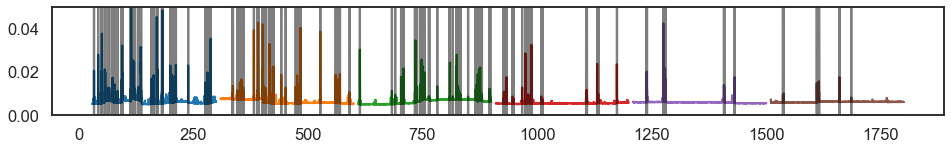

In [9]:
nf = 11
data_tot = []
n_flies = len(exp_list)
expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
data_dict_raw = dataUtils.load_timeseries_simple(exp_list[nf][0], exp_list[nf][1], dirs['data'])
if expt_id=='2022_01_21_fly2':
    data_dict_raw['ball'][data_dict_raw['ball']>0.1]=0.1
print(expt_id)   

data_dict=copy.deepcopy(data_dict_raw)
beh = np.zeros(data_dict['ball'].shape)
U = np.unique(data_dict['trialFlag'])
sig = sig_list[expt_id]

plt.figure(figsize=(16,2))
for i in range(len(U)):
    uid = data_dict['trialFlag'][:,0]==U[i]
    beh[uid] = dataUtils.binarize_timeseries_by_outliers(data_dict['ball'][uid], sig=sig[i]) #0.5
    plt.plot(data_dict['time'][uid], data_dict['ball'][uid,:])
plt.plot(data_dict['time'], .05*beh, 'k', alpha=.5)
plt.ylim(0,.05*beh.max())
plt.show()



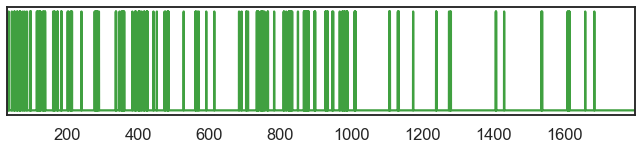

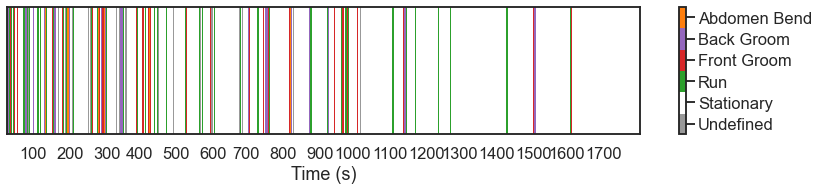

In [10]:
plt.figure(figsize=(11.25,2))
plt.plot(data_dict['time'], .05*beh, 'g', alpha=.75)
plt.xlim(data_dict['time'][0],data_dict['time'][-1])
plt.yticks([])
plt.show()

data_dict_temp = copy.deepcopy(data_dict)
data_dict_temp['tPl'] = data_dict_temp['time']
plotting.plot_states_simple(data_dict_temp)

([], [])

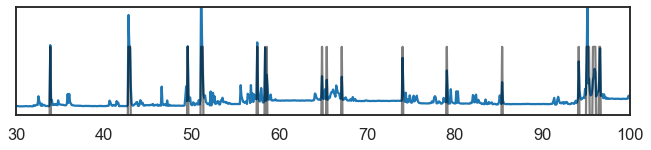

In [11]:
plt.figure(figsize=(11,2))
for i in range(len(U)):
    uid = data_dict['trialFlag'][:,0]==U[i]
    plt.plot(data_dict['time'][uid], data_dict['ball'][uid,:])

plt.plot(data_dict['time'], .02*beh, 'k', alpha=.5)
plt.ylim(0.003,.03)
plt.xlim(30,100)
plt.yticks([])

(0.0, 820.0)

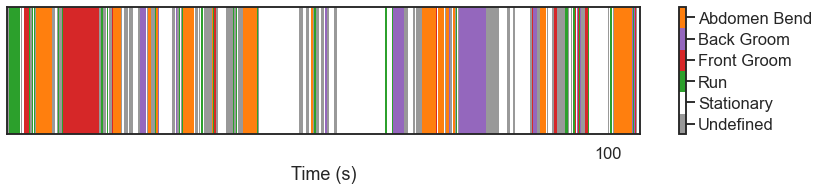

In [12]:
plotting.plot_states_simple(data_dict_temp)
plt.xlim(0,820)

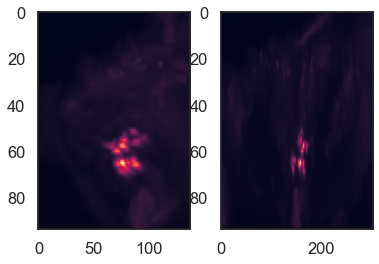

In [144]:
plt.subplot(121)
plt.imshow( data_dict['im_R'].max(axis=1), aspect='auto' )
plt.subplot(122)
plt.imshow( data_dict['im_R'].max(axis=2), aspect='auto' )


In [97]:
data_dict.keys()

dict_keys(['time', 'trialFlag', 'dFF', 'dYY', 'dRR', 'ball', 'dlc', 'beh_labels', 'stim', 'drink', 'dims', 'dims_in_um', 'dims_in_um_orig', 'im', 'im_R', 'scanRate', 'redTh', 'grnTh', 'goodIds', 'oIsGood', 'PIDdata', 'aligned_centroids', 'centroid_is_red', 'A'])

(-0.5, 57.5, 50.5, -0.5)

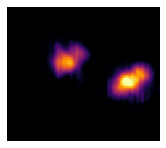

In [162]:
plt.subplot(121)
im = data_dict['im'].max(axis=1)
plt.imshow(im,cmap=plt.get_cmap('inferno'))
plt.clim(15000,60000)
# plt.imshow(crs) 
plt.gca().axis('off')


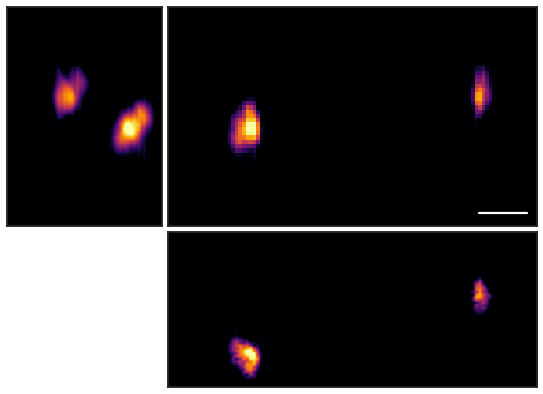

In [203]:
R = data_dict['im']/data_dict['im'].max()
color_lims = [20000,60000]

from matplotlib import colors

dims_in_um = data_dict['dims_in_um']
dims = data_dict['dims']
cmap = plt.get_cmap('inferno') #plotting.make_hot_without_black()

totScale = 1
totWidth = 1.1*(dims_in_um[2] + dims_in_um[1])
zpx = dims_in_um[2]/totWidth
ypx = dims_in_um[1]/totWidth
xpx = dims_in_um[0]/totWidth

totScale = 1
plt.figure(figsize=(8, 8*totScale))

totWidth = 1.1*(dims_in_um[2] + dims_in_um[1])
zpx = dims_in_um[2]/totWidth
ypx = dims_in_um[1]/totWidth
xpx = dims_in_um[0]/totWidth

ax2 = plt.axes([.05+zpx,  (.05+zpx)/totScale,  ypx,  xpx/totScale])
ax1 = plt.axes([.04,      (.05+zpx)/totScale,  zpx,  xpx/totScale])
ax3 = plt.axes([.05+zpx,  .04/totScale,      ypx,  zpx/totScale])


cs1 = ax1.imshow(np.max(data_dict['im'],axis=1), cmap=cmap, aspect='auto');
cs1.set_clim(color_lims[0], color_lims[-1])
ax1.set_xticks([])
ax1.set_yticks([])

cs2 = ax2.imshow(np.max(data_dict['im'],axis=2), cmap=cmap, aspect='auto');
cs2.set_clim(color_lims[0], color_lims[-1])
ax2.set_xticks([])
ax2.set_yticks([])
# axes[0, 1].set_title('Top')

ypx_per_um = dims[1]/dims_in_um[1]
scaleBar_um = 50 #50 um
# bar_color = 'k' if cmap=='bwr' else 'w'
bar_color = 'w'
ax2.plot( dims[1]*.97-(scaleBar_um*ypx_per_um,0), (dims[0]*.93, dims[0]*.93),bar_color)


cs3 = ax3.imshow(np.max(data_dict['im'],axis=0).T, cmap=cmap, aspect='auto');
cs3.set_clim(color_lims[0], color_lims[-1])
ax3.set_xticks([])
ax3.set_yticks([])
# axes[1, 1].set_title('Front')
plt.savefig(fig_dirs['fig_folder'] + expt_id +'_im.pdf',transparent=True, bbox_inches='tight')


In [202]:
fig_dirs['fig_folder'] + expt_id +'_im.pdf'

'/Users/evan/Dropbox/_AxelLab/__flygenvectors/figs/2022_01_19_fly1/2022_01_19_fly1_im.pdf'

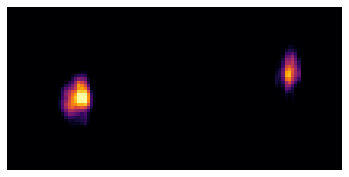

In [163]:

# plt.subplot(121)
# im = data_dict['im'].max(axis=1)
# plt.imshow(im,cmap=plt.get_cmap('inferno'))
# plt.clim(15000,65123)
# # plt.imshow(crs) 
# plt.gca().axis('off')

# plt.subplot(122)
im = data_dict['im'].max(axis=2)

# ax = plt.subplot2grid(grid_tuple, roi_subplot, colspan=1, rowspan=4)
plt.imshow(im,cmap=plt.get_cmap('inferno'))
plt.clim(15000,60000)
# plt.imshow(crs) 
plt.gca().axis('off')

fig_dirs = futils.get_fig_dirs(expt_id)
# plt.savefig(fig_dirs['fig_folder'] + expt_id +'_im.pdf',transparent=True, bbox_inches='tight')
plt.show()

In [29]:
states['states']

NameError: name 'states' is not defined

In [17]:
# data_dict['tPl']=data_dict['time']
# # old_diff = data_dict['tPl'][data_dict['trialFlag']==2][0] - data_dict['tPl'][data_dict['trialFlag']==1][-1]
# # new_diff = data_dict['tPl'][data_dict['trialFlag']==1][-1] - data_dict['tPl'][data_dict['trialFlag']==1][-2]
# # data_dict['tPl'][data_dict['trialFlag']>1] -= old_diff+new_diff
# data_dict['behavior']=beh
# plotting.show_raster_with_behav(data_dict,color_range=(-3,40),include_feeding=False,include_dlc=False)


In [51]:
# beginning and end of trial 2
data_dict['tPl'][data_dict['trialFlag']==2][[0,-1]]

array([ 709.81748319, 1399.4543708 ])

In [53]:
# index of beginning of trial 2
np.flatnonzero(data_dict['trialFlag']==2)[0]

6704

In [48]:
data_dict['tPl'][6704]/60

array([11.83029139])

In [66]:
# steps into trial 2 for stim
data_dict['scanRate']*60*(4+44/60)

2842.7307692307695

In [67]:
# steps into whole exp for stim
np.flatnonzero(data_dict['trialFlag']==2)[0] + data_dict['scanRate']*60*(4+44/60)

9546.73076923077

In [65]:
1/np.diff(data_dict['tPl'][:3,0])

array([10.00961538, 10.00961538])

In [49]:
data_dict['beh_labels'].shape

(6824, 6)

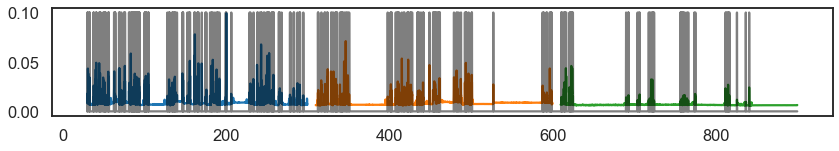

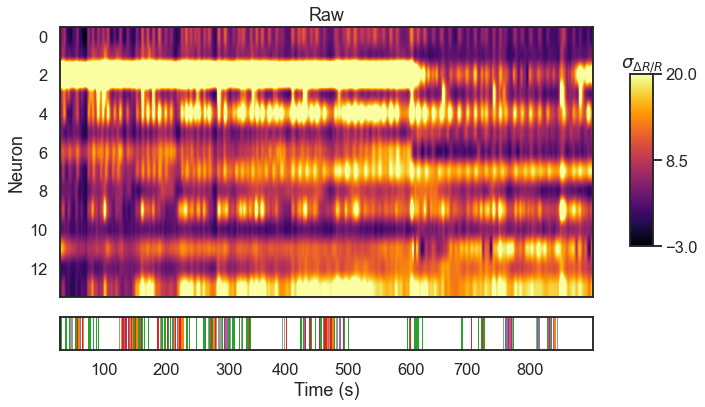

In [52]:
reload(model)
data_dict=copy.deepcopy(data_dict_raw)
override_labels = False
# data_dict['tPl']=data_dict['time']
# data_dict['behavior']=data_dict['ball']
if override_labels:
    data_dict['beh_labels'] = np.array([[]])
#model.trim_before_stim(data_dict)


beh = np.zeros(data_dict['ball'].shape)
U = np.unique(data_dict['trialFlag'])
sig = sig_list[expt_id]

plt.figure(figsize=(14,2))
for i in range(len(U)):
    uid = data_dict['trialFlag'][:,0]==U[i]
    beh[uid] = dataUtils.binarize_timeseries_by_outliers(data_dict['ball'][uid], sig=sig[i]) #0.5
    plt.plot(data_dict['time'][uid], data_dict['ball'][uid,:])
plt.plot(data_dict['time'], .1*beh, 'k', alpha=.5)
plt.show()

data_dict['tPl']=data_dict['time']
if override_labels:
    data_dict['behavior']=beh
    plotting.show_raster_with_behav(data_dict,color_range=(-3,20),split_behavior=False)
else:
    data_dict['behavior'] = data_dict['beh_labels'][:,2].copy() #1*(data_dict['beh_labels'][:,0]==1)
    plotting.show_raster_with_behav(data_dict,color_range=(-3,20),split_behavior=False, include_beh_labels=True)

## test beh params

In [50]:
# reload(model)
# nf=5
# expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
# print(expt_id)
# fig_dirs = futils.get_fig_dirs(expt_id)
# data_dict = dataUtils.load_timeseries_simple(exp_list[nf][0], exp_list[nf][1], dirs['data'])


# # behavior
# beh = np.zeros(data_dict['ball'].shape)
# U = np.unique(data_dict['trialFlag'])
# sig = sig_list[expt_id]
# for i in range(len(U)):
#     uid = data_dict['trialFlag'][:,0]==U[i]
#     beh[uid] = dataUtils.binarize_timeseries_by_outliers(data_dict['ball'][uid], sig=sig[i]) #0.5

# ball = data_dict['ball'].copy()
# data_dict['ball'] = beh.copy()
# data_dict['tPl'] = data_dict['time'].copy()
# data_dict['behavior'] = beh.copy()
# if True: #len(data_dict['beh_labels'])<2:
#     data_dict['beh_labels'] = beh.copy()-beh.mean()
#     get_behav_from_ball = True
# else:
#     data_dict['behavior'] = data_dict['beh_labels'][:,2].copy() #1*(data_dict['beh_labels'][:,0]==1)
#     get_behav_from_ball = False

# ro = model.reg_obj(exp_id=expt_id, 
#                data_dict=copy.deepcopy(data_dict),
#                fig_dirs=fig_dirs,
#                split_behav=split_behav,
#                use_beh_labels=use_beh_labels)

# ro.get_smooth_behavior()


In [51]:
# plt.figure(figsize=(15,4))
# plt.subplot(311)
# plt.plot(ball)
# plt.subplot(312)
# plt.plot(data_dict['behavior'])
# plt.subplot(313)
# plt.plot(ro.data_dict['behavior'])

# process datasets

In [13]:
dilp_dh44_use_beh_labels = {}
dilp_dh44_use_beh_labels['2020_08_28_fly1'] = True
dilp_dh44_use_beh_labels['2020_08_24_fly1'] = True
dilp_dh44_use_beh_labels['2020_08_10_fly1'] = True
dilp_dh44_use_beh_labels['2020_08_10_fly2'] = False
dilp_dh44_use_beh_labels['2020_07_29_fly2'] = True
dilp_dh44_use_beh_labels['2019_05_20_fly2'] = False
dilp_dh44_use_beh_labels['2019_05_20_fly3'] = False
dilp_dh44_use_beh_labels['2019_05_14_fly3'] = False
dilp_dh44_use_beh_labels['2019_05_14_fly4'] = False
dilp_dh44_use_beh_labels['2019_05_13_fly1'] = False
dilp_dh44_use_beh_labels['2019_11_12_fly5'] = False
dilp_dh44_use_beh_labels['2019_11_12_fly6'] = False


In [14]:
dilp_dh44_use_beh_labels['2020_08_10_fly2']

False

In [18]:
trim_stim = False
failed_label_list = ['2020_08_10_fly2', '2019_11_12_fly5', '2019_11_12_fly6']

reload(model)
# exp_list = [exp_list[5]]
# for nf in range(len(exp_list)):
# for nf in range(7,len(exp_list)):
# for nf in [3]:
for nf in range(len(exp_list)):
    print(str(nf)+' of '+str(len(exp_list)-1), end=', ')
    
    expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
    print(expt_id)
    
    fig_dirs = futils.get_fig_dirs(expt_id)
    data_dict = dataUtils.load_timeseries_simple(exp_list[nf][0], exp_list[nf][1], dirs['data'])

    if expt_id=='2019_04_26_fly1':
        # fix old annotation mistake
        data_dict['stim'][10000]=1
    elif expt_id=='2019_04_25_fly1':
        # fix old annotation mistake
        data_dict['stim'][9547]=1
    elif expt_id=='2022_01_21_fly2':
        data_dict['ball'][data_dict['ball']>0.1]=0.1

    #     if expt_id=='2019_08_19_fly1_1':
    #         is_ok = np.array([True]*len(data_dict['time']))
    #         is_ok[5500:6800] = False
    #         data_dict['time'] = data_dict['time'][is_ok]
    #         data_dict['trialFlag'] = data_dict['trialFlag'][is_ok]
    #         data_dict['dFF'] = data_dict['dFF'][:,is_ok]
    #         data_dict['dYY'] = data_dict['dYY'][:,is_ok]
    #         data_dict['dRR'] = data_dict['dRR'][:,is_ok]
    #         data_dict['ball'] = data_dict['ball'][is_ok]
    #         data_dict['dlc'] = data_dict['dlc'][is_ok]
    #         data_dict['beh_labels'] = data_dict['beh_labels'][is_ok]
    #         data_dict['stim'] = data_dict['stim'][is_ok]
    #         data_dict['drink'] = data_dict['drink'][is_ok]
        
    #if 'beh_labels' not in data_dict or (len(data_dict['beh_labels'])==0):
    #    data_dict['beh_labels'] = np.array([[]])
    
    if trim_stim:
        model.trim_before_stim(data_dict)

    # behavior
    beh = np.zeros(data_dict['ball'].shape)
    U = np.unique(data_dict['trialFlag'])
    sig = sig_list[expt_id]
    for i in range(len(U)):
        uid = data_dict['trialFlag'][:,0]==U[i]
        beh[uid] = dataUtils.binarize_timeseries_by_outliers(data_dict['ball'][uid], sig=sig[i]) #0.5
    data_dict['ball'] = beh.copy()
    data_dict['tPl'] = data_dict['time'].copy()
    data_dict['behavior'] = beh.copy()
    if len(data_dict['beh_labels'])<2:
        data_dict['beh_labels'] = beh.copy()
        get_behav_from_ball = True
    elif expt_id in failed_label_list:
        data_dict['beh_labels'] = beh.copy()
        get_behav_from_ball = True
    else:
        data_dict['behavior'] = data_dict['beh_labels'][:,2].copy() #1*(data_dict['beh_labels'][:,0]==1)
        get_behav_from_ball = False
    get_behav_from_ball = True
        
    if oviDN: 
        #    get_behav_from_ball = True
        #    print('getting behav from ball')
        data_dict['dFF'] = np.concatenate( (data_dict['dFF'], data_dict['dFF']), axis=0 )
    
    #data_dict['state_is_valid'] = define_valid_state_from_short_bouts(data_dict, t_thresh=1)
    data_dict['state_is_valid'] = np.ones(len(data_dict['time']),dtype=bool)

    if dilp:
        use_beh_labels = dilp_dh44_use_beh_labels[expt_id]
      
    # run full processing
    ro = model.reg_obj(exp_id=expt_id, 
                   data_dict=copy.deepcopy(data_dict),
                   fig_dirs=fig_dirs,
                   split_behav=split_behav,
                   use_beh_labels=use_beh_labels)
    
    ro.data_dict = ro.preprocess(get_behav_from_ball=get_behav_from_ball, ignore_isgood=ignore_isgood)
    pickle.dump( ro.data_dict, open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "wb" ) )


0 of 11, 2020_08_28_fly1
Number of cores: 48
1 of 11, 2020_08_24_fly1
Number of cores: 48
2 of 11, 2020_08_10_fly1
Number of cores: 48
3 of 11, 2020_08_10_fly2
Number of cores: 48
4 of 11, 2020_07_29_fly2
Number of cores: 48
5 of 11, 2019_05_20_fly2
Number of cores: 48
6 of 11, 2019_05_20_fly3
Number of cores: 48
7 of 11, 2019_05_14_fly3
Number of cores: 48
8 of 11, 2019_05_14_fly4
Number of cores: 48
9 of 11, 2019_05_13_fly1
Number of cores: 48
10 of 11, 2019_11_12_fly5
Number of cores: 48
11 of 11, 2019_11_12_fly6
Number of cores: 48


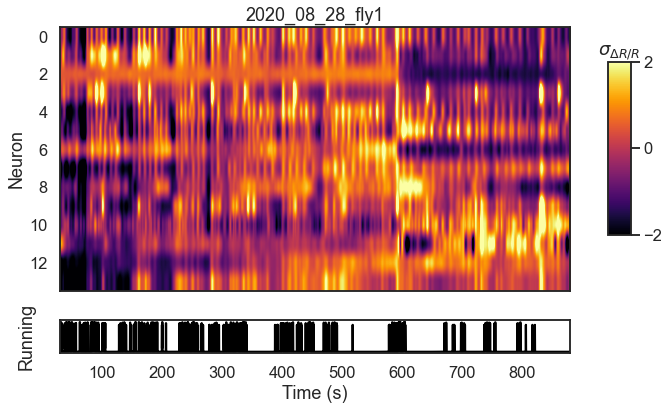

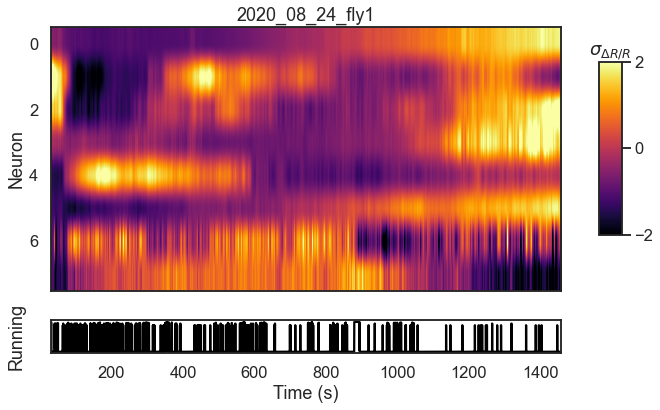

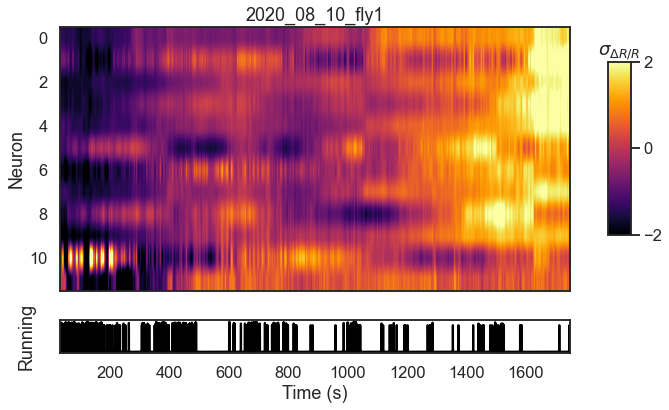

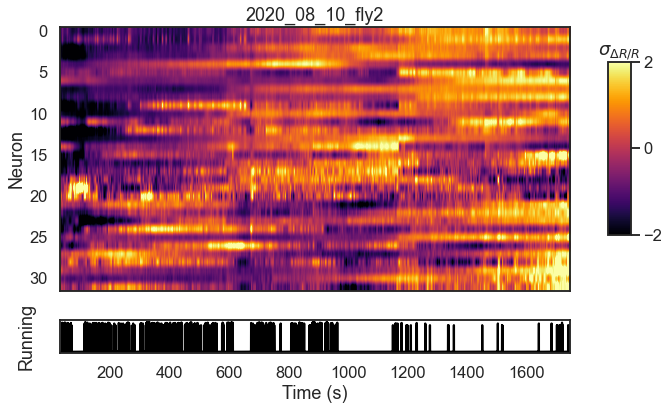

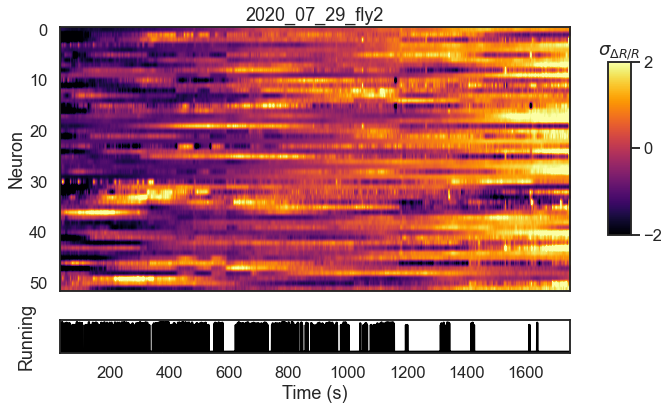

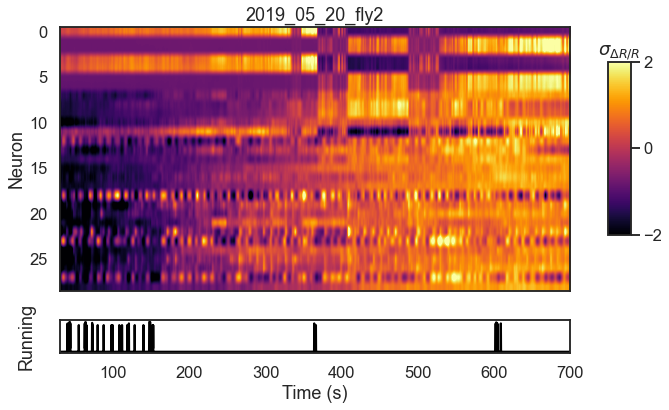

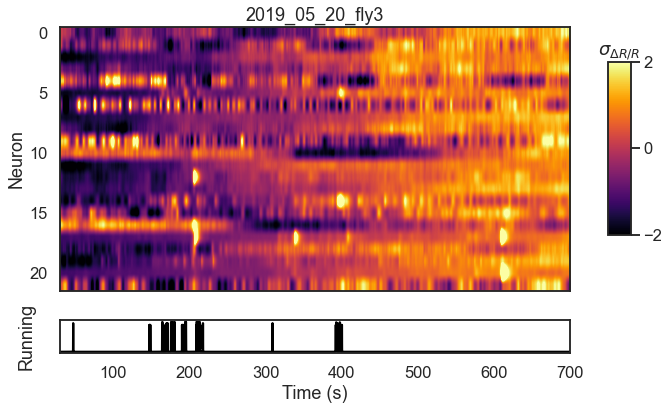

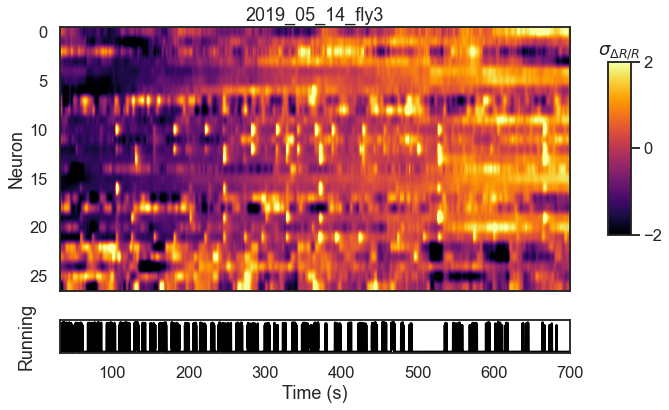

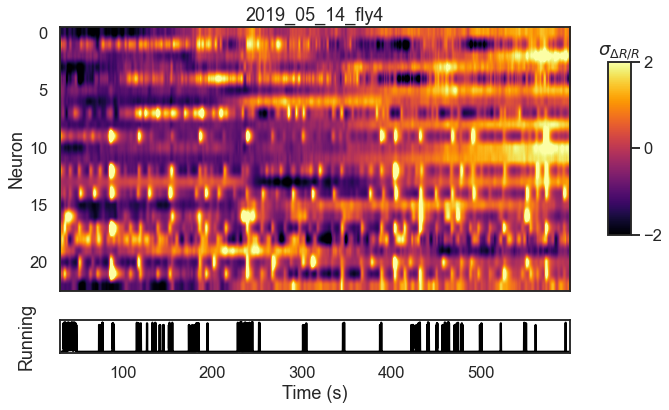

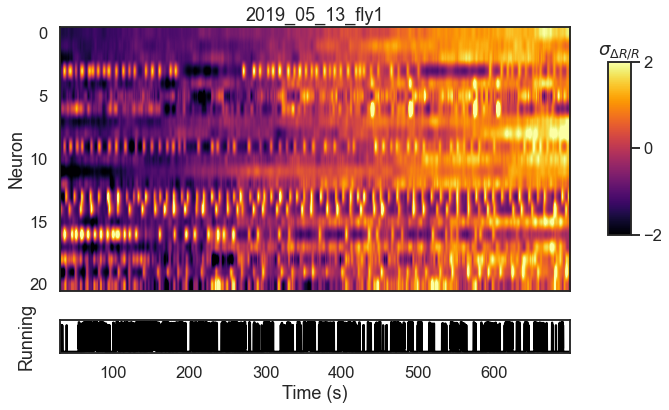

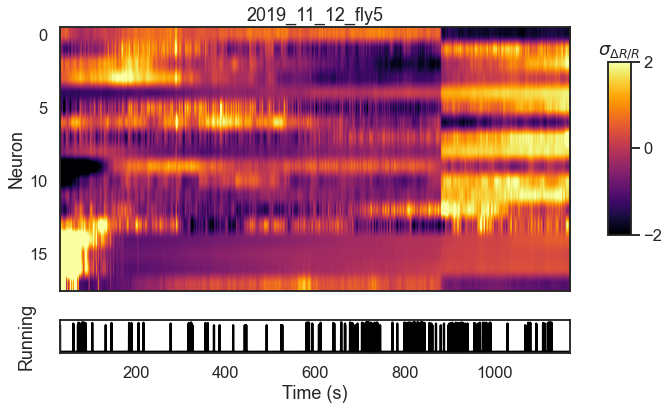

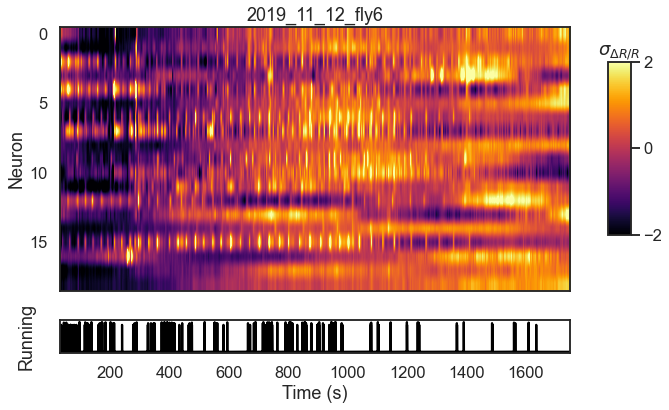

In [147]:
# tests
reload(plotting)

for nf in range(len(exp_list)):
    # for nf in range(len(exp_list)):
    expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
    fig_dirs = futils.get_fig_dirs(expt_id)
    ro.data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )
    
    plotting.show_raster_with_behav(ro.data_dict,color_range=(-2,2),
                                    title=expt_id, sort=False, include_beh_labels=False, split_behavior=False)
    #plt.savefig(fig_dirs['fig_folder']+expt_id +'_raster.pdf',transparent=False, bbox_inches='tight')
    plt.show()


## cleanup of CrzDh44 & Dilp datasets

In [20]:
list_Dilp = [
            ['2020_08_28','fly1'],
            ['2020_08_24','fly1'],
            ['2020_08_10','fly1'],
            ['2020_08_10','fly2'],
            ['2020_07_29','fly2'],
            ['2019_11_12','fly5'],
            ['2019_11_12','fly6'],
            ]

list_Dh44 = [
            ['2019_05_20','fly2'],
            ['2019_05_20','fly3'],
            ['2019_05_14','fly3'],
            ['2019_05_14','fly4'],
            ['2019_05_13','fly1'],
            ]


#### Dilp

[ True  True  True  True  True  True  True  True  True  True]


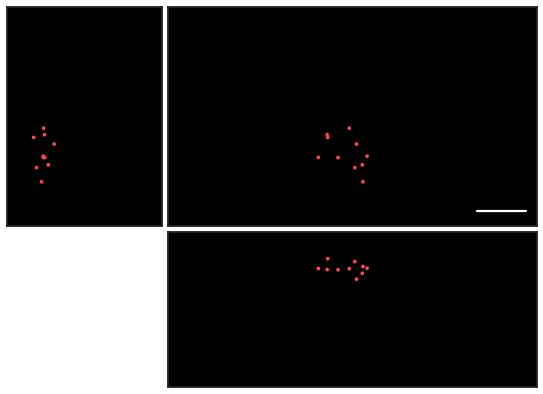

[ True  True  True]


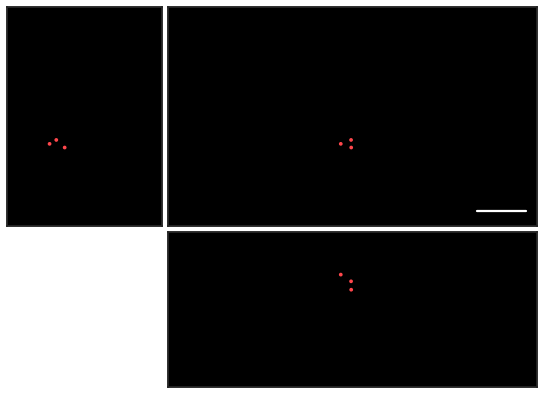

[ True  True  True  True  True  True  True  True  True  True]


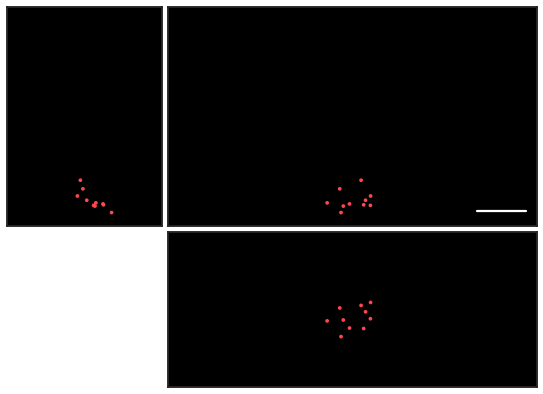

[ True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False]


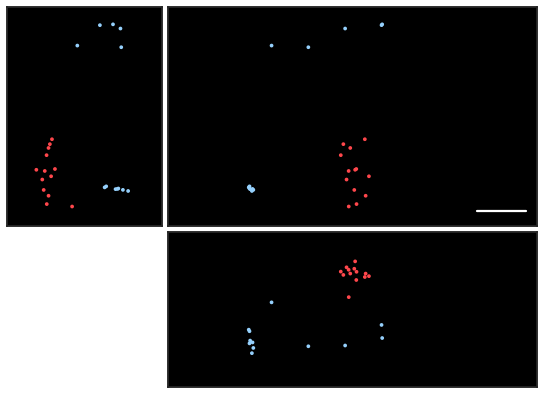

[ True  True  True  True  True False False False  True False  True False
 False  True  True False  True False False  True  True False False  True
 False  True]


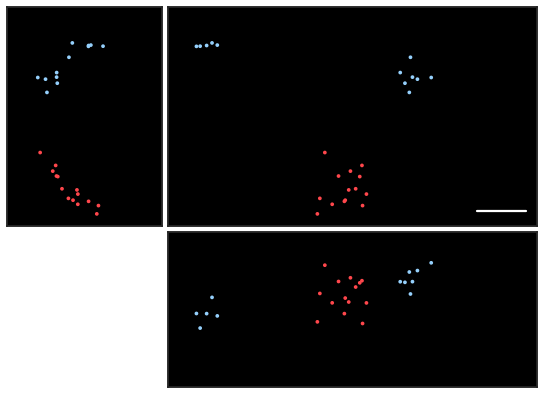

[ True  True  True  True  True  True  True  True  True  True  True  True
 False False False]


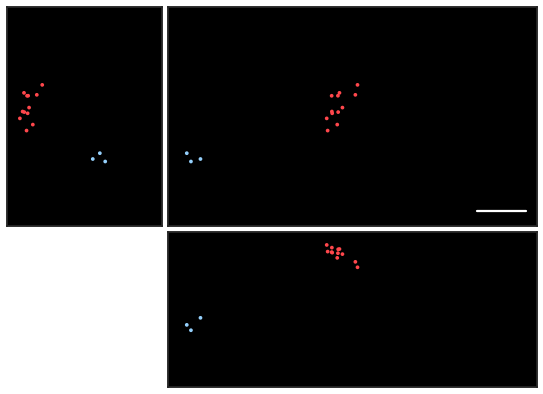

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]


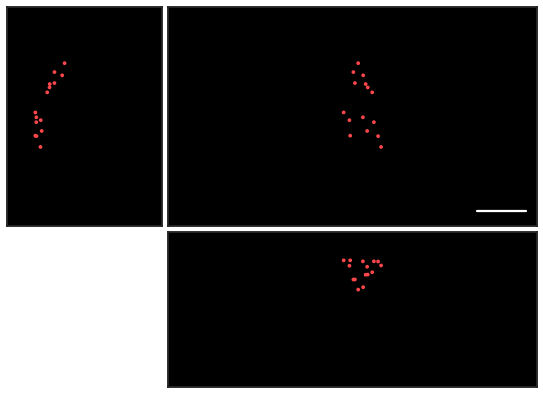

In [34]:
for nf in range(len(list_Dilp)):
    expt_id = list_Dilp[nf][0] + '_' + list_Dilp[nf][1]
    fig_dirs = futils.get_fig_dirs(expt_id)
    data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )

          
    isgood = (data_dict['aligned_centroids'][:,0]<230)*(
                data_dict['aligned_centroids'][:,0]>150)*(
                data_dict['aligned_centroids'][:,1]>50)
    print(isgood)
    
    # visualization
    idx = -1*np.ones(data_dict['aligned_centroids'].shape[0])
    idx[isgood] += 2
    
    color_lims = plotting.show_colorCoded_cellMap_points(data_dict, idx, idx, 
                                                         cmap=plotting.cold_to_hot_cmap(), sort_by='val', 
                                                         point_size=5)
    #plt.savefig(fig_dirs['regfig_folder']+expt_id+'_cc_'+param_label+'_tauLess5_map.pdf',transparent=False, bbox_inches='tight')
    plt.show() 
    
    # save result
    data_dict['dFF'] = data_dict['dFF'][isgood,:]
    data_dict['dYY'] = data_dict['dYY'][isgood,:]
    data_dict['dRR'] = data_dict['dRR'][isgood,:]
    data_dict['aligned_centroids'] = data_dict['aligned_centroids'][isgood,:]
    data_dict['A'] = data_dict['A'][:,isgood]
    pickle.dump( data_dict, open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "wb" ) )


#### CrzDh44

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


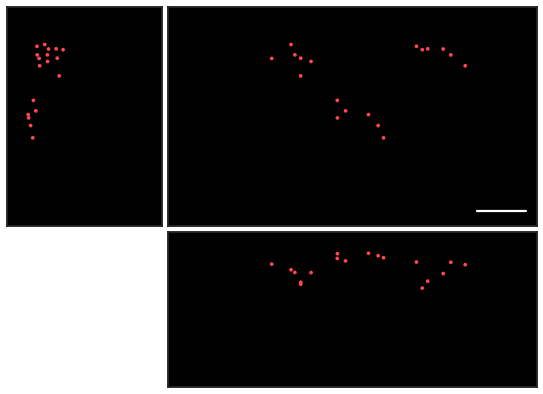

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]


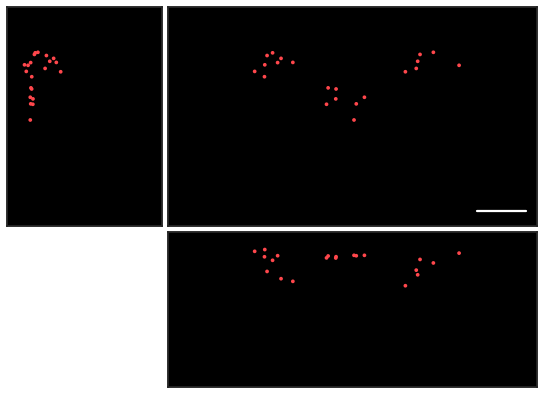

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False]


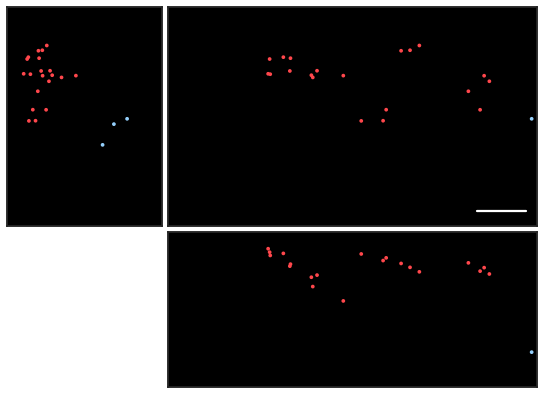

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]


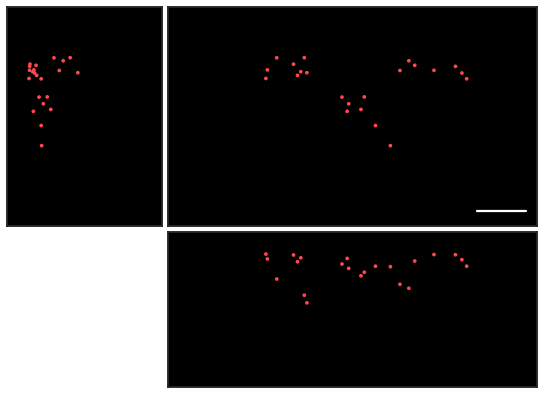

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]


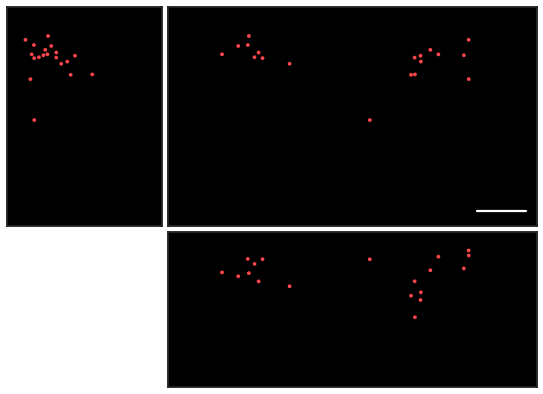

In [42]:
for nf in range(len(list_Dh44)):
    expt_id = list_Dh44[nf][0] + '_' + list_Dh44[nf][1]
    fig_dirs = futils.get_fig_dirs(expt_id)
    data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )

          
    isgood = (data_dict['aligned_centroids'][:,0]<340)*(
                data_dict['aligned_centroids'][:,0]>10)*(
                data_dict['aligned_centroids'][:,1]>10)
    print(isgood)
    
    # visualization
    idx = -1*np.ones(data_dict['aligned_centroids'].shape[0])
    idx[isgood] += 2
    
    color_lims = plotting.show_colorCoded_cellMap_points(data_dict, idx, idx, 
                                                         cmap=plotting.cold_to_hot_cmap(), sort_by='val', 
                                                         point_size=5)
    #plt.savefig(fig_dirs['regfig_folder']+expt_id+'_cc_'+param_label+'_tauLess5_map.pdf',transparent=False, bbox_inches='tight')
    plt.show() 
    
    # save result
    data_dict['dFF'] = data_dict['dFF'][isgood,:]
    data_dict['dYY'] = data_dict['dYY'][isgood,:]
    data_dict['dRR'] = data_dict['dRR'][isgood,:]
    data_dict['aligned_centroids'] = data_dict['aligned_centroids'][isgood,:]
    data_dict['A'] = data_dict['A'][:,isgood]
    pickle.dump( data_dict, open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "wb" ) )


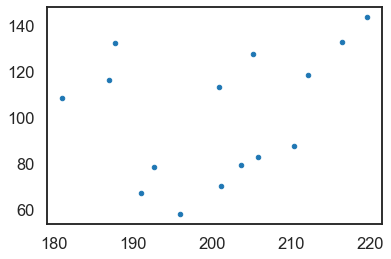

In [26]:
plt.plot(data_dict['aligned_centroids'][:,0],
        data_dict['aligned_centroids'][:,1],'.')

## manual cleanup of oviDN datasets

In [166]:
# remove end of run 4 (equipment issue)
nf=-2
expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
print(expt_id)
if expt_id=='2022_01_21_fly2':
    cut_pt = 15500
    fig_dirs = futils.get_fig_dirs(expt_id)
    data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )
    
    l = len(data_dict['behavior'])
    e4 = np.flatnonzero(data_dict['trialFlag']==4)[-1]
    keep = [i for i in range(cut_pt)] + [i for i in range(e4+1,l)]
    
    data_dict['dFF'] = data_dict['dFF'][:,keep]
    data_dict['dYY'] = data_dict['dYY'][:,keep]
    data_dict['dRR'] = data_dict['dRR'][:,keep]
    data_dict['time'] = data_dict['time'][keep]
    data_dict['tPl'] = data_dict['tPl'][keep]
    data_dict['behavior'] = data_dict['behavior'][keep]
    data_dict['ball'] = data_dict['ball'][keep,:]
    data_dict['beh_labels'] = data_dict['beh_labels'][keep, :]
    data_dict['trialFlag'] = data_dict['trialFlag'][keep]
    data_dict['state_is_valid'] = data_dict['state_is_valid'][keep]
    pickle.dump( data_dict, open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "wb" ) )

2022_01_21_fly2


In [167]:
# remove run 13 (equipment issue)
nf=0
expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
print(expt_id)
if expt_id=='2022_01_05_fly2':
    fig_dirs = futils.get_fig_dirs(expt_id)
    data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )
    e4 = np.flatnonzero(data_dict['trialFlag']==12)[-1]
    keep = [i for i in range(e4)]
    
    data_dict['dFF'] = data_dict['dFF'][:,keep]
    data_dict['dYY'] = data_dict['dYY'][:,keep]
    data_dict['dRR'] = data_dict['dRR'][:,keep]
    data_dict['time'] = data_dict['time'][keep]
    data_dict['tPl'] = data_dict['tPl'][keep]
    data_dict['behavior'] = data_dict['behavior'][keep]
    data_dict['ball'] = data_dict['ball'][keep,:]
    data_dict['beh_labels'] = data_dict['beh_labels'][keep, :]
    data_dict['trialFlag'] = data_dict['trialFlag'][keep]
    data_dict['state_is_valid'] = data_dict['state_is_valid'][keep]
    pickle.dump( data_dict, open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "wb" ) )

2022_01_05_fly2


In [168]:
# remove run 6 (no behavior)
nf=-3
expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
print(expt_id)
if expt_id=='2022_01_19_fly1':
    fig_dirs = futils.get_fig_dirs(expt_id)
    data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )
    e4 = np.flatnonzero(data_dict['trialFlag']==5)[-1]
    keep = [i for i in range(e4)]
    
    data_dict['dFF'] = data_dict['dFF'][:,keep]
    data_dict['dYY'] = data_dict['dYY'][:,keep]
    data_dict['dRR'] = data_dict['dRR'][:,keep]
    data_dict['time'] = data_dict['time'][keep]
    data_dict['tPl'] = data_dict['tPl'][keep]
    data_dict['behavior'] = data_dict['behavior'][keep]
    data_dict['ball'] = data_dict['ball'][keep,:]
    data_dict['beh_labels'] = data_dict['beh_labels'][keep, :]
    data_dict['trialFlag'] = data_dict['trialFlag'][keep]
    data_dict['state_is_valid'] = data_dict['state_is_valid'][keep]
    pickle.dump( data_dict, open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "wb" ) )

2022_01_19_fly1


# tests

In [15]:
# for nf in [2,-1]:
#     print(str(nf)+' of '+str(len(exp_list)-1))
#     expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
#     fig_dirs = futils.get_fig_dirs(expt_id)
    
#     ro.data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )
#     ro.data_dict['behavior'] = ro.data_dict['beh_labels'][:,2].copy()
#     pickle.dump( ro.data_dict, open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "wb" ) )

In [54]:
ro = model.reg_obj(exp_id=expt_id, 
                   data_dict=copy.deepcopy(data_dict),
                   fig_dirs=fig_dirs,
                   split_behav=split_behav,
                   use_beh_labels=use_beh_labels)

Number of cores: 48


In [75]:
ro = model.reg_obj(exp_id=[], 
                   data_dict=[],
                   fig_dirs=[],
                   split_behav=False,
                   use_beh_labels=False)


Number of cores: 48


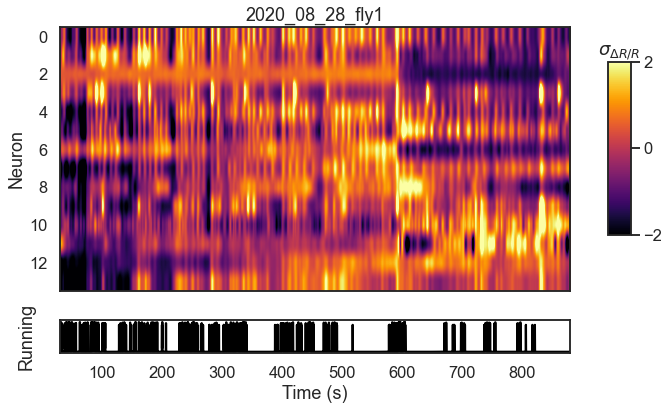

In [76]:
reload(plotting)

for nf in [-1]:
    # for nf in range(len(exp_list)):
    expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
    fig_dirs = futils.get_fig_dirs(expt_id)
    ro.data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )
    
    plotting.show_raster_with_behav(ro.data_dict,color_range=(-2,2),
                                    title=expt_id, sort=False, include_beh_labels=False, split_behavior=False)
    plt.savefig(fig_dirs['fig_folder']+expt_id +'_raster.pdf',transparent=False, bbox_inches='tight')
    plt.show()


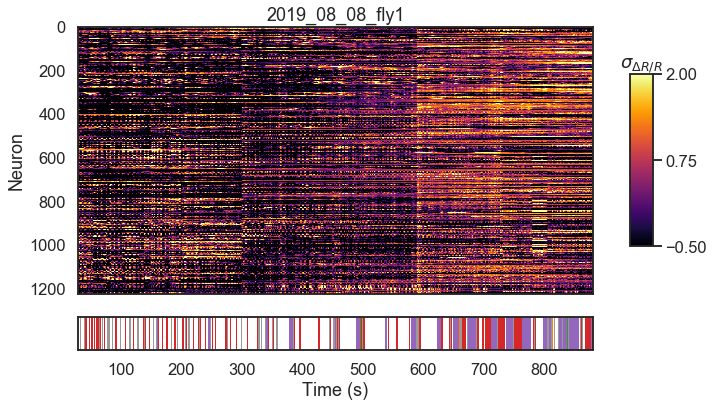

In [35]:
reload(plotting)

for nf in [-1]:
    # for nf in range(len(exp_list)):
    expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
    fig_dirs = futils.get_fig_dirs(expt_id)
    ro.data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )
    
    plotting.show_raster_with_behav(ro.data_dict,color_range=(-.5,2),
                                    title=expt_id, sort=False, include_beh_labels=True, split_behavior=False)
    plt.savefig(fig_dirs['fig_folder']+expt_id +'_raster.pdf',transparent=False, bbox_inches='tight')
    plt.show()


In [12]:
ro.data_dict.keys()

dict_keys(['time', 'trialFlag', 'dFF', 'dYY', 'dRR', 'ball', 'dlc', 'beh_labels', 'stim', 'drink', 'dims', 'dims_in_um', 'dims_in_um_orig', 'im', 'scanRate', 'redTh', 'grnTh', 'goodIds', 'oIsGood', 'PIDdata', 'aligned_centroids', 'centroid_is_red', 'A', 'tPl', 'behavior', 'state_is_valid', 'dt', 'dFF_unnormalized', 'dFF_mag_norm', 'q0', 'q1', 'mu', 'sig', 'train_all', 'val_all'])

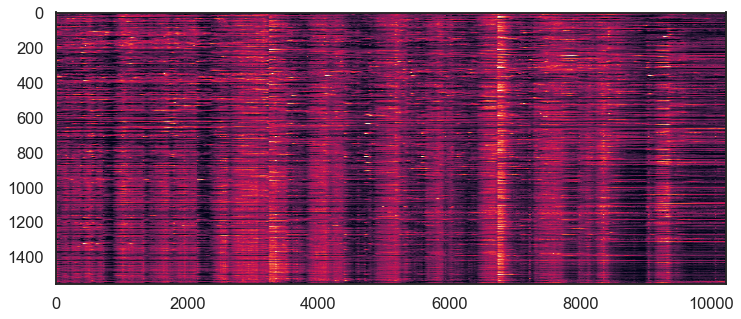

In [22]:
plt.figure(figsize=(12,5))
plt.imshow(ro.data_dict['dFF'],aspect='auto')
plt.clim(-.02,.05)

(150, 250)

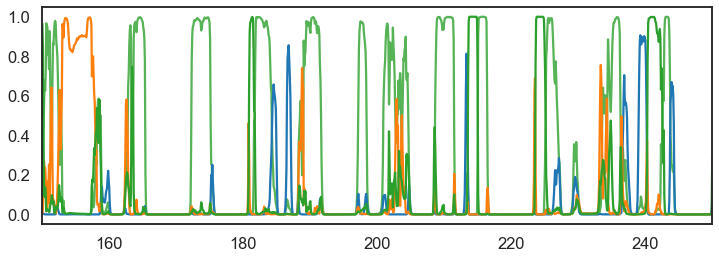

In [35]:
plt.figure(figsize=(12,4))
plt.plot(data_dict['tPl'],data_dict['beh_labels'][:,2],'tab:green',alpha=.8)
plt.plot(data_dict['tPl'],data_dict['beh_labels'][:,3])
plt.plot(data_dict['tPl'],data_dict['beh_labels'][:,4])
plt.plot(data_dict['tPl'],data_dict['beh_labels'][:,5])
plt.xlim(150,250)

## processing sandbox to test cell exclusion criteria

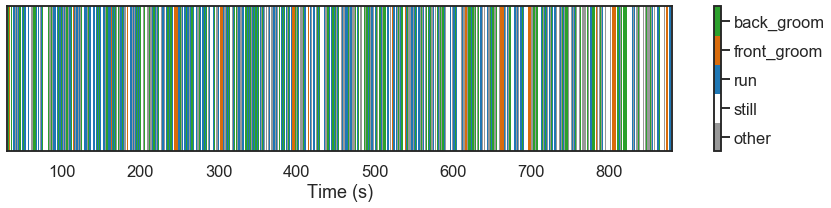

In [23]:
reload(plotting)
# data_dict_plt = copy.deepcopy(data_dict)
# data_dict_plt['beh_labels'] = np.expand_dims(np.argmax(data_dict['beh_labels'],axis=1),axis=1)
plotting.plot_states_simple(ro.data_dict)


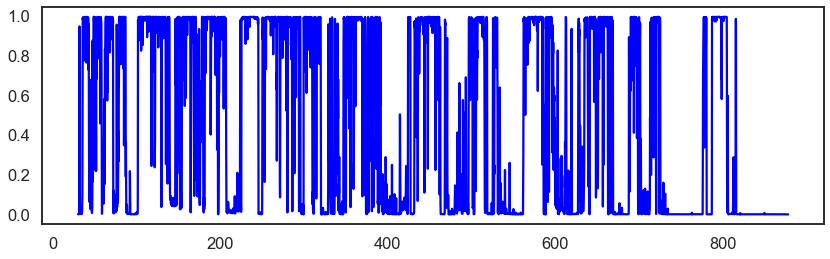

In [37]:
plt.figure(figsize=(14,4))

# plt.plot(data_dict['tPl'], data_dict['beh_labels'][:,1],'k')
plt.plot(data_dict['tPl'], data_dict['beh_labels'][:,2],'b')
# plt.plot(data_dict['tPl'], data_dict['beh_labels'][:,4],'g')
# plt.xlim(100,300)

In [36]:

reload(model)
nf=2
expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
print(expt_id)
fig_dirs = futils.get_fig_dirs(expt_id)
data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )



2019_07_01_fly2


In [34]:
data_dict['beh_labels'].shape

(19083, 5)

## optional pruning transient behaviors (now done by default above)

In [20]:
# data_dict_prune = copy.deepcopy(data_dict)
# data_dict_prune['dFF'] =   data_dict_prune['dFF'][:,nund]
# data_dict_prune['dYY'] =   data_dict_prune['dYY'][:,nund] 
# data_dict_prune['dRR'] =   data_dict_prune['dRR'][:,nund] 
# data_dict_prune['time'] = data_dict_prune['time'][nund]
# data_dict_prune['tPl'] =   data_dict_prune['tPl'][nund]
# data_dict_prune['behavior'] =     data_dict_prune['behavior'][nund]
# data_dict_prune['ball'] =     data_dict_prune['ball'][nund]
# data_dict_prune['trialFlag'] =   data_dict_prune['trialFlag'][nund]
# data_dict_prune['beh_labels'] = data_dict_prune['beh_labels'][nund]

In [25]:
reload(model)
# for nf in [2,-1]:
for nf in range(len(exp_list)):
    print(str(nf)+' of '+str(len(exp_list)-1))
    expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
    fig_dirs = futils.get_fig_dirs(expt_id)
    data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )
    
    data_dict['state_is_valid'] = define_valid_state_from_short_bouts(data_dict, t_thresh=1)
    pickle.dump( data_dict, open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "wb" ) )


0 of 3
1 of 3
2 of 3
3 of 3


# checks

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa672fbe588>,
      dtype=object)

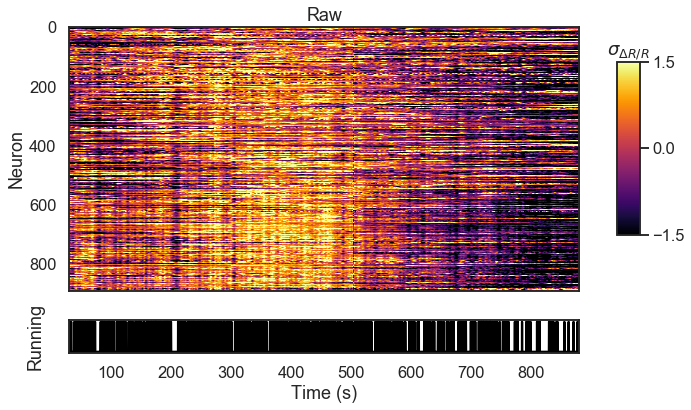

In [37]:
plotting.show_raster_with_behav(ro.data_dict,color_range=(-1.5,1.5),include_feeding=False,include_dlc=False)


In [126]:
# temporarily copy pkls to one location for convenient export (to cluster)
staging_folder = '/Users/evan/Desktop/'+'flygenvectors_pkl_copy5/'
os.mkdir(staging_folder)

# for nf in [-5,-4]:
for nf in range(len(exp_list)):
    expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
    fig_dirs = futils.get_fig_dirs(expt_id)
    filename = fig_dirs['pkl_dir'] + expt_id +'_dict.pkl'
    shutil.copy(filename, staging_folder)

In [127]:
os.listdir(staging_folder)

['2019_04_25_fly1_dict.pkl',
 '2019_04_22_fly1_dict.pkl',
 '2019_04_26_fly1_dict.pkl',
 '2019_04_24_fly3_dict.pkl',
 '2019_04_22_fly3_dict.pkl',
 '2019_04_18_fly2_dict.pkl',
 '2019_04_25_fly2_dict.pkl',
 '2019_04_25_fly3_dict.pkl',
 '2019_04_29_fly1_dict.pkl',
 '2019_04_24_fly1_dict.pkl',
 '2019_05_07_fly1_dict.pkl']

# sandbox

### v2: remove transient behaviors in aligned tseries

In [151]:
nf = -1
data_tot = []
n_flies = len(exp_list)
expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
data_dict = dataUtils.load_timeseries_simple(exp_list[nf][0], exp_list[nf][1], dirs['data'])
fig_dirs = futils.get_fig_dirs(expt_id)

In [154]:
states_in = {'states':data_dict['beh_labels'][:,0].astype(int)}

In [155]:
states_1s = remove_transient_behaviors(states_in, frame_th=data_dict['scanRate'])
states_hs = remove_transient_behaviors(states_in, frame_th=.5*data_dict['scanRate'])

print((states_in['states']==4).sum()/len(states_1s['states']))
print((states_hs['states']==4).sum()/len(states_1s['states']))
print((states_1s['states']==4).sum()/len(states_1s['states']))

0.14335060449050085
0.24654576856649396
0.3391083765112263


In [156]:
data_dict.keys()

dict_keys(['time', 'trialFlag', 'dFF', 'dYY', 'dRR', 'ball', 'dlc', 'beh_labels', 'stim', 'drink', 'dims', 'dims_in_um', 'dims_in_um_orig', 'im', 'scanRate', 'redTh', 'grnTh', 'goodIds', 'oIsGood', 'PIDdata', 'aligned_centroids', 'centroid_is_red', 'A'])

In [162]:
data_dict['ball'][:10].shape, ro.data_dict['behavior'][:10].shape

((10, 1), (10,))

In [145]:
states_1s = remove_transient_behaviors(states_in, frame_th=data_dict['scanRate'])
states_hs = remove_transient_behaviors(states_in, frame_th=.5*data_dict['scanRate'])

print((states_in['states']==4).sum()/len(states_1s['states']))
print((states_hs['states']==4).sum()/len(states_1s['states']))
print((states_1s['states']==4).sum()/len(states_1s['states']))

0.08808497845475499
0.2424090590239503
0.34582623509369675


In [149]:
states = remove_transient_behaviors(states_in, frame_th=.95*data_dict['scanRate'])

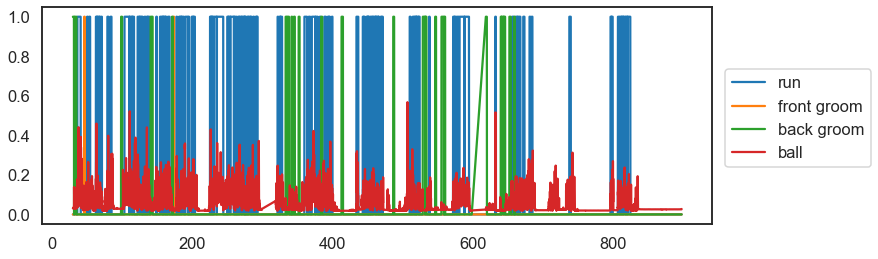

In [150]:
plt.figure(figsize=(12,4))
plt.plot(data_dict['time'], states['states']==1, label='run')
plt.plot(data_dict['time'], states['states']==2, label='front groom')
plt.plot(data_dict['time'], states['states']==3, label='back groom')
plt.plot(data_dict['time'], 5*data_dict['ball'], label='ball')
# plt.xlim(30,60)
plt.legend(bbox_to_anchor=(1.25, .75), loc='upper right', ncol=1)
# plt.xlim(625,825)
# plt.savefig( fig_dirs['regfig_folder']+expt_id+'_beh_label_validation_ex1.pdf',transparent=True, bbox_inches='tight')
plt.show()

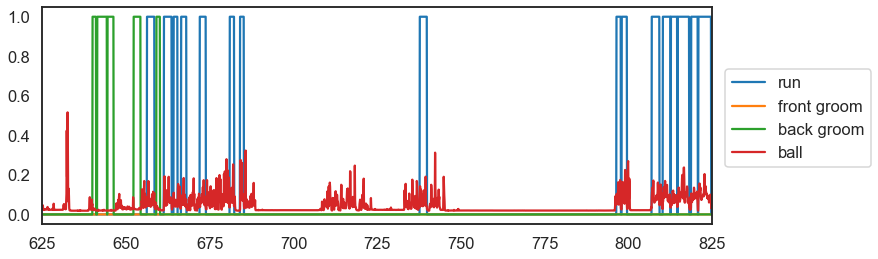

In [146]:
plt.figure(figsize=(12,4))
plt.plot(data_dict['time'], states['states']==1, label='run')
plt.plot(data_dict['time'], states['states']==2, label='front groom')
plt.plot(data_dict['time'], states['states']==3, label='back groom')
plt.plot(data_dict['time'], 5*data_dict['ball'], label='ball')
# plt.xlim(30,60)
plt.legend(bbox_to_anchor=(1.25, .75), loc='upper right', ncol=1)
plt.xlim(625,825)
# plt.savefig( fig_dirs['regfig_folder']+expt_id+'_beh_label_validation_ex1.pdf',transparent=True, bbox_inches='tight')
plt.show()

### v1: beh labels as is

In [102]:
nf = 2
data_tot = []
n_flies = len(exp_list)
expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
data_dict = dataUtils.load_timeseries_simple(exp_list[nf][0], exp_list[nf][1], dirs['data'])
fig_dirs = futils.get_fig_dirs(expt_id)

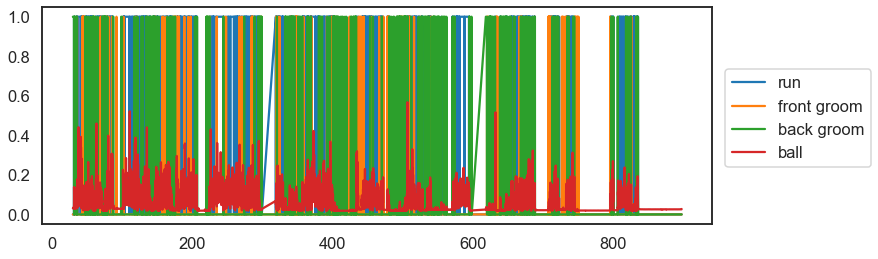

In [105]:
plt.figure(figsize=(12,4))
plt.plot(data_dict['time'], data_dict['beh_labels'][:,0]==1, label='run')
plt.plot(data_dict['time'], data_dict['beh_labels'][:,0]==2, label='front groom')
plt.plot(data_dict['time'], data_dict['beh_labels'][:,0]==3, label='back groom')
plt.plot(data_dict['time'], 5*data_dict['ball'], label='ball')
# plt.xlim(30,60)
plt.legend(bbox_to_anchor=(1.25, .75), loc='upper right', ncol=1)
# plt.xlim(625,825)
plt.savefig( fig_dirs['regfig_folder']+expt_id+'_beh_label_validation_ex0.pdf',transparent=True, bbox_inches='tight')
plt.show()

In [56]:
ro.data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )

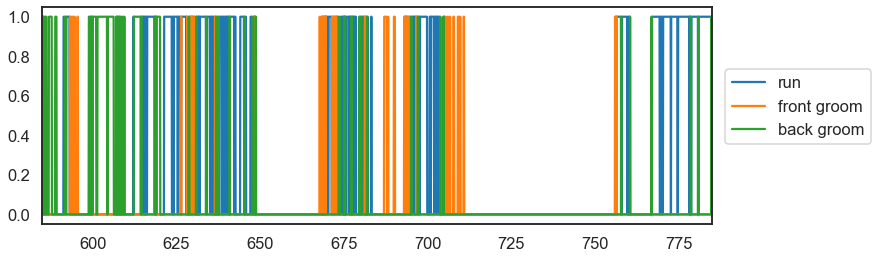

In [68]:
plt.figure(figsize=(12,4))
plt.plot(ro.data_dict['tPl'], ro.data_dict['beh_labels'][:,0]==1, label='run')
plt.plot(ro.data_dict['tPl'], ro.data_dict['beh_labels'][:,0]==2, label='front groom')
plt.plot(ro.data_dict['tPl'], ro.data_dict['beh_labels'][:,0]==3, label='back groom')
# plt.plot(data_dict['time'], 5*data_dict['ball'], label='ball')
# plt.xlim(30,60)
plt.legend(bbox_to_anchor=(1.25, .75), loc='upper right', ncol=1)
plt.xlim(585,785)
plt.savefig( fig_dirs['regfig_folder']+expt_id+'_beh_labels_ex1.pdf',transparent=True, bbox_inches='tight')
plt.show()

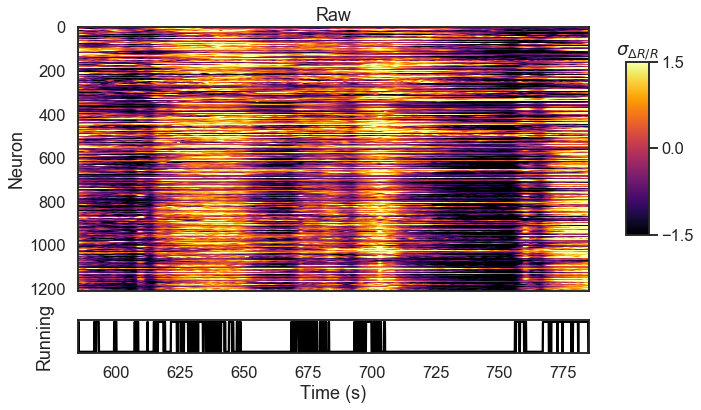

In [69]:
# t1 = np.argmin(abs(ro.data_dict['tPl']-660))
# t2 = np.argmin(abs(ro.data_dict['tPl']-725))
# t1 = np.argmin(abs(ro.data_dict['tPl']-740))
# t2 = np.argmin(abs(ro.data_dict['tPl']-785))
t1 = np.argmin(abs(ro.data_dict['tPl']-585))
t2 = np.argmin(abs(ro.data_dict['tPl']-785))
plotting.show_raster_with_behav(ro.data_dict,color_range=(-1.5,1.5), time_lims=(t1,t2))
plt.savefig( fig_dirs['regfig_folder']+expt_id+'_beh_labels_ex1_im.pdf',transparent=True, bbox_inches='tight')


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9fd187e438>,
      dtype=object)

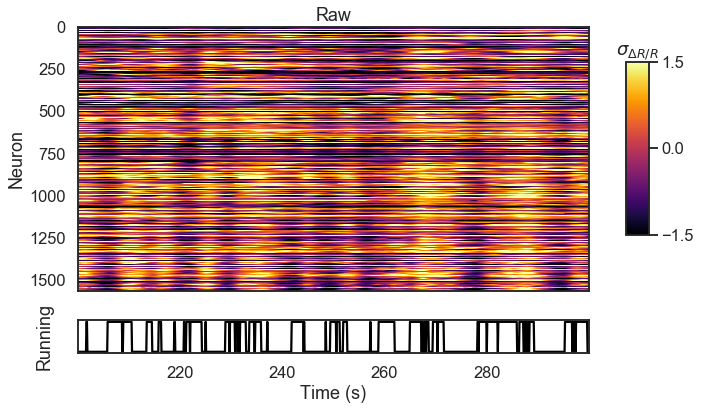

In [115]:
t1 = np.argmin(abs(ro.data_dict['tPl']-200))
t2 = np.argmin(abs(ro.data_dict['tPl']-300))
plotting.show_raster_with_behav(ro.data_dict,color_range=(-1.5,1.5), time_lims=(t1,t2))


In [70]:
nf = -1
data_tot = []
n_flies = len(exp_list)
expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
data_dict = dataUtils.load_timeseries_simple(exp_list[nf][0], exp_list[nf][1], dirs['data'])
fig_dirs = futils.get_fig_dirs(expt_id)

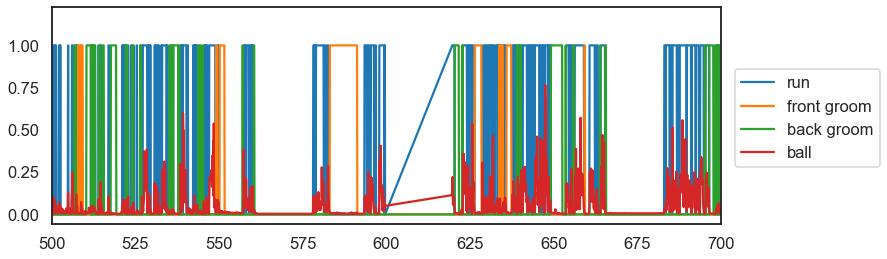

In [107]:
plt.figure(figsize=(12,4))
plt.plot(data_dict['time'], data_dict['beh_labels'][:,0]==1, label='run')
plt.plot(data_dict['time'], data_dict['beh_labels'][:,0]==2, label='front groom')
plt.plot(data_dict['time'], data_dict['beh_labels'][:,0]==3, label='back groom')
plt.plot(data_dict['time'], 5*data_dict['ball'], label='ball')
# plt.xlim(30,60)
plt.legend(bbox_to_anchor=(1.25, .75), loc='upper right', ncol=1)
plt.xlim(500,700)
# plt.savefig( fig_dirs['regfig_folder']+expt_id+'_beh_label_validation_ex1.pdf',transparent=True, bbox_inches='tight')
plt.show()

In [73]:
ro.data_dict = pickle.load( open( fig_dirs['pkl_dir'] + expt_id +'_dict.pkl', "rb" ) )

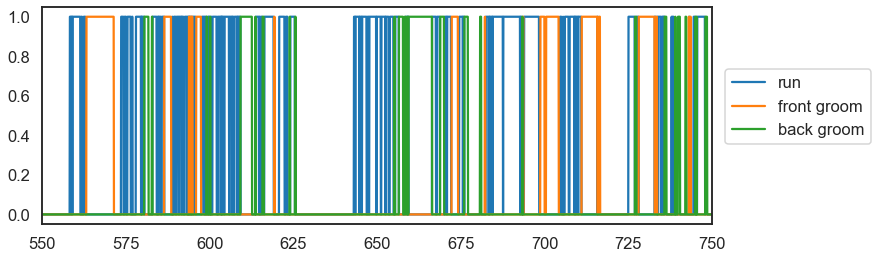

In [110]:
plt.figure(figsize=(12,4))
plt.plot(ro.data_dict['tPl'], ro.data_dict['beh_labels'][:,0]==1, label='run')
plt.plot(ro.data_dict['tPl'], ro.data_dict['beh_labels'][:,0]==2, label='front groom')
plt.plot(ro.data_dict['tPl'], ro.data_dict['beh_labels'][:,0]==3, label='back groom')
# plt.plot(data_dict['time'], 5*data_dict['ball'], label='ball')
# plt.xlim(30,60)
plt.legend(bbox_to_anchor=(1.25, .75), loc='upper right', ncol=1)
plt.xlim(550,750)
plt.savefig( fig_dirs['regfig_folder']+expt_id+'_beh_labels_ex3.pdf',transparent=True, bbox_inches='tight')
plt.show()

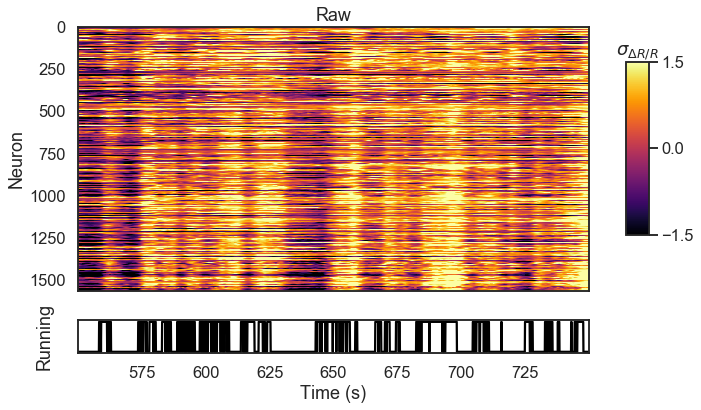

In [112]:
t1 = np.argmin(abs(ro.data_dict['tPl']-550))
t2 = np.argmin(abs(ro.data_dict['tPl']-750))
plotting.show_raster_with_behav(ro.data_dict,color_range=(-1.5,1.5), time_lims=(t1,t2))
plt.savefig( fig_dirs['regfig_folder']+expt_id+'_beh_labels_ex3_im.pdf',transparent=True, bbox_inches='tight')


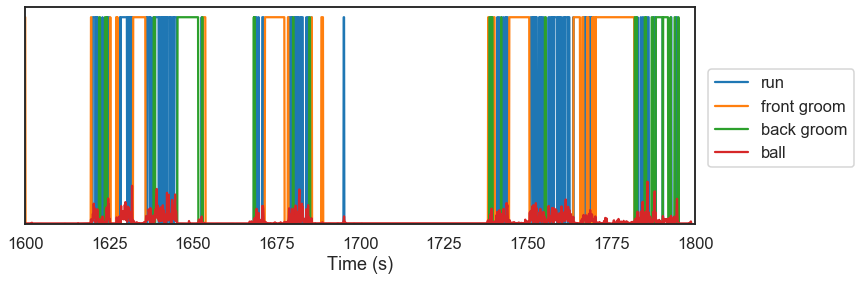

In [85]:
plt.figure(figsize=(12,4))
plt.plot(data_dict['time'], data_dict['beh_labels'][:,0]==1, label='run')
plt.plot(data_dict['time'], data_dict['beh_labels'][:,0]==2, label='front groom')
plt.plot(data_dict['time'], data_dict['beh_labels'][:,0]==3, label='back groom')
plt.plot(data_dict['time'], 5*data_dict['ball'], label='ball')
# plt.xlim(30,60)
plt.legend(bbox_to_anchor=(1.25, .75), loc='upper right', ncol=1)
plt.xlim(1600,1800)
plt.xlabel('Time (s)')
plt.ylim(0,1.05)
plt.yticks([])
plt.savefig( fig_dirs['regfig_folder']+expt_id+'_beh_label_validation_ex2.pdf',transparent=True, bbox_inches='tight')
plt.show()

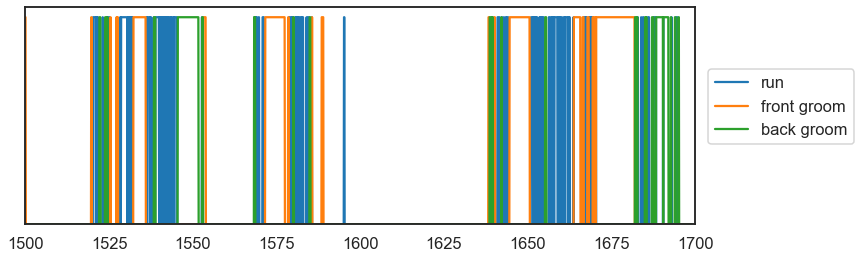

In [86]:
plt.figure(figsize=(12,4))
plt.plot(ro.data_dict['tPl'], ro.data_dict['beh_labels'][:,0]==1, label='run')
plt.plot(ro.data_dict['tPl'], ro.data_dict['beh_labels'][:,0]==2, label='front groom')
plt.plot(ro.data_dict['tPl'], ro.data_dict['beh_labels'][:,0]==3, label='back groom')
# plt.plot(data_dict['time'], 5*data_dict['ball'], label='ball')
# plt.xlim(30,60)
plt.legend(bbox_to_anchor=(1.25, .75), loc='upper right', ncol=1)
plt.xlim(1500,1700)
plt.ylim(0,1.05)
plt.yticks([])
plt.savefig( fig_dirs['regfig_folder']+expt_id+'_beh_labels_ex2.pdf',transparent=True, bbox_inches='tight')
plt.show()

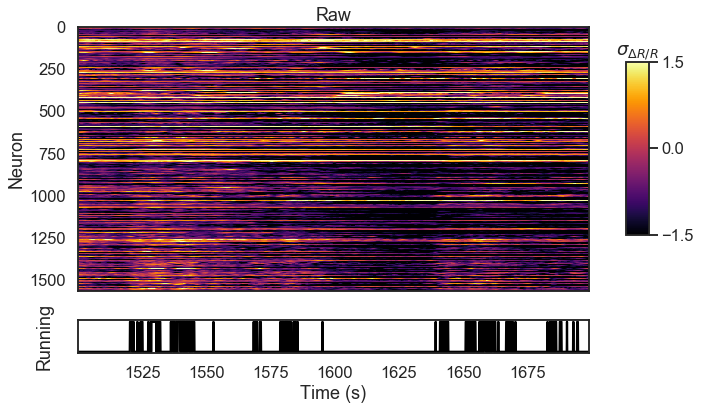

In [89]:
t1 = np.argmin(abs(ro.data_dict['tPl']-1500))
t2 = np.argmin(abs(ro.data_dict['tPl']-1700))
plotting.show_raster_with_behav(ro.data_dict,color_range=(-1.5,1.5), time_lims=(t1,t2))
plt.savefig( fig_dirs['regfig_folder']+expt_id+'_beh_labels_ex2_im.pdf',transparent=True, bbox_inches='tight')


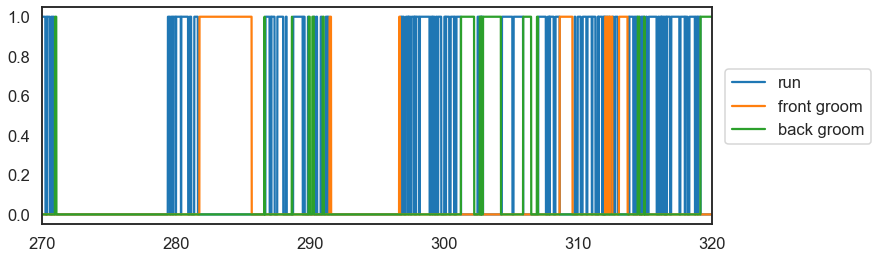

In [80]:
plt.figure(figsize=(12,4))
plt.plot(time-4, states['states']==1, label='run')
plt.plot(time-4, states['states']==2, label='front groom')
plt.plot(time-4, states['states']==3, label='back groom')
plt.xlim(270,320)
# plt.xlim(30,60)
plt.legend(bbox_to_anchor=(1.25, .75), loc='upper right', ncol=1)


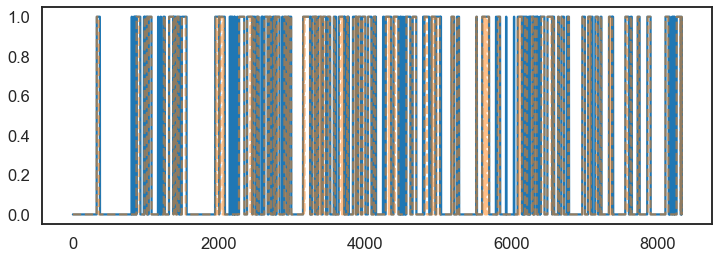

In [33]:
# compare behavior label timeseries (and raw)

nf = 3
data_dict_old = dataUtils.load_timeseries_simple(exp_list[nf][0], exp_list[nf][1], dirs['data'])
data_dict_raw = dataUtils.load_timeseries_simple(exp_list[nf][0], exp_list[nf][1], dirs['data'])

plt.figure(figsize=(12,4))
plt.plot(data_dict_old['beh_labels']==3)
plt.plot(data_dict_raw['beh_labels']==3,'--',alpha=.5)

expt_id = exp_list[nf][0] + '_' + exp_list[nf][1]
fig_dirs = futils.get_fig_dirs(expt_id)
beh_raw = pickle.load( open( '/Users/evan/Dropbox/_AxelLab/__flygenvectors/datashare/_rawBehavior/states-v2.1/2019_10_14_fly3_beh-states-heuristic.pkl', "rb" ) )

plt.figure(figsize=(12,4))
plt.plot(beh_raw['states']==2)
plt.xlim(10000,50000)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb221372d68>,
      dtype=object)

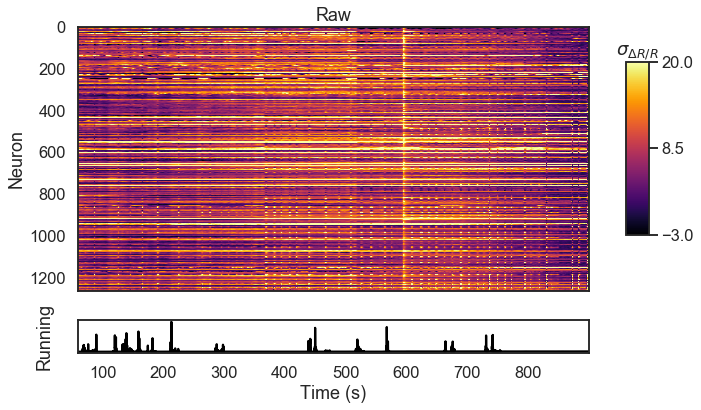

In [10]:
data_dict = dataUtils.load_timeseries_simple('2019_08_14', 'fly3_2', dirs['data'])
data_dict['tPl'] = data_dict['time'].copy()
data_dict['behavior'] = data_dict['ball'].copy()
plotting.show_raster_with_behav(data_dict,color_range=(-3,20),include_feeding=False,include_dlc=False)



In [115]:
a = np.array([1,2,3,4,5])
b = np.zeros(5,dtype=bool)
b[[1,3]]=True
a[b]

array([2, 4])

In [117]:
np.max(b[:1])

False

# sandbox

In [85]:
if expt_id=='2019_08_19_fly1_1':
    is_ok = np.array([True]*len(data_dict['time']))
    is_ok[5500:6800] = False
    data_dict['time'] = data_dict['time'][is_ok]
    data_dict['trialFlag'] = data_dict['trialFlag'][is_ok]
    data_dict['dFF'] = data_dict['dFF'][:,is_ok]
    data_dict['dYY'] = data_dict['dYY'][:,is_ok]
    data_dict['dRR'] = data_dict['dRR'][:,is_ok]
    data_dict['ball'] = data_dict['ball'][is_ok]
    data_dict['dlc'] = data_dict['dlc'][is_ok]
    data_dict['beh_labels'] = data_dict['beh_labels'][is_ok]
    data_dict['stim'] = data_dict['stim'][is_ok]
    data_dict['drink'] = data_dict['drink'][is_ok]
    data_dict['tPl'] = data_dict['tPl'][is_ok]
    data_dict['behavior'] = data_dict['behavior'][is_ok]
    